In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline 

In [7]:
data = pd.read_csv('./combined6files/data_10mhz-between fingers_10min.csv')

In [8]:
data.head()

,x,evmSampleDeltaMs,logDeltaMs,DATA0_uH,DATA1_uH,DATA2_uH,DATA3_uH,DATA0,DATA1,DATA2,DATA3,DIFF0,DIFF1,DIFF2,DIFF3,DATA0_MHz,DATA1_MHz,DATA2_MHz,DATA3_MHz,Unnamed: 19
0,0,6.134469e+08,6.134469e+08,8.767457,8.700816,Infinity,Infinity,18301070,18371022,0,0,-69952,69952,0,0,2.958873,2.970183,0,0,NaN
1,1,3.041304e+00,7.284036e+00,8.767457,8.700816,Infinity,Infinity,18301070,18371022,0,0,-69952,69952,0,0,2.958873,2.970183,0,0,NaN
2,2,1.964849e+00,6.943229e+00,8.767457,8.700816,Infinity,Infinity,18301070,18371022,0,0,-69952,69952,0,0,2.958873,2.970183,0,0,NaN
3,3,1.988092e+00,5.009472e+00,8.767309,8.700816,Infinity,Infinity,18301225,18371022,0,0,-69797,69797,0,0,2.958898,2.970183,0,0,NaN
4,4,3.352528e+00,6.340704e+00,8.767309,8.700816,Infinity,Infinity,18301225,18371022,0,0,-69797,69797,0,0,2.958898,2.970183,0,0,NaN


In [9]:
data1 = data.DATA1_uH.astype(np.float32)[603:-403]

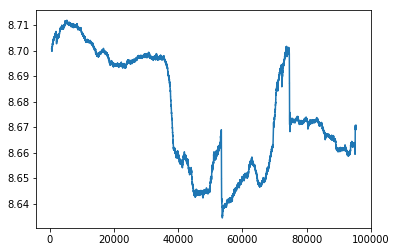

In [10]:
data1.plot()

In [11]:
data = data.DATA0_uH.astype(np.float32)[603:-403]

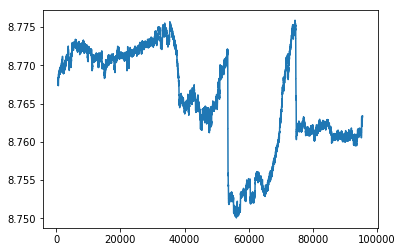

In [12]:
data.plot()

In [15]:
## rough sample frequency 

print(data.shape[0])
sample_freq = data.shape[0]/(10*60)
print("sample frequency(Hz):",sample_freq)

94800
sample frequency(Hz): 158.0


In [16]:
X = data.values.reshape((-1,158))

In [17]:
X.shape

(600, 158)

In [18]:
# data preparation.....
# since we only have a long series with one target value so far
# we would assume target valus is one (doesn't matter since we can see it as a normalized value)
# the potential goal here is to see if Linear Regressio model can point out the most influential frequency bins to 
# predict the concentration level
train_X_raw,valid_X_raw = train_test_split(X,random_state=13)
train_X_fft,valid_X_fft = np.abs(np.fft.fft(train_X_raw))[:,2:80],np.abs(np.fft.fft(valid_X_raw))[:,2:80]
train_y,valid_y = np.ones((450,1)),np.ones((150,1))

Text(0.5,1,'fft input example')

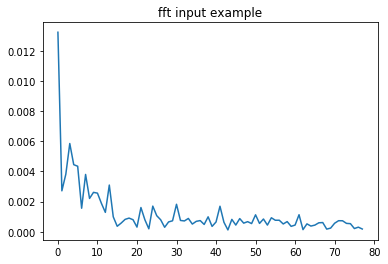

In [22]:
plt.plot(train_X_fft[0])
plt.title("fft input example")

In [23]:
### train a simple linear regression model to see 
### which frequency bins are most influential to represent the concentration level
lr_model = LinearRegression(fit_intercept=False,normalize=True)
lr_model.fit(train_X_fft,train_y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

In [24]:
# take a peak on the weights of linear regression
lr_model.coef_

array([[   5.5965705,    5.467556 ,    8.887787 ,    9.978645 ,
           0.7933006,   -2.713646 ,   21.355453 ,   23.724367 ,
           2.3776894,   33.579445 ,   17.219782 ,   74.26239  ,
          52.525383 ,   78.151344 ,   77.22986  ,   32.011196 ,
          32.910973 ,   17.23999  ,  -71.3779   , -147.89203  ,
        -186.46957  ,   88.54161  ,   21.514149 ,  102.59596  ,
          48.295074 ,   39.82809  ,  103.65444  ,  105.26022  ,
          66.20422  ,  116.23717  ,   89.34181  ,   66.28595  ,
          63.44153  ,   23.822893 ,  -47.564445 ,  131.09972  ,
         -29.419397 ,  111.38011  , -124.964745 , -170.4444   ,
         102.83367  , -194.97858  ,   35.3206   ,   -5.7245817,
        -141.28403  , -174.08673  ,   43.981064 ,  -46.69543  ,
        -142.7792   ,  -67.82408  ,   33.505634 ,  -40.393284 ,
        -180.46675  ,  -52.337807 ,   19.58118  ,   -4.9241133,
         -33.772964 , -194.03186  , -283.48822  ,  -72.63462  ,
          53.27428  ,  -59.993046 ,   41

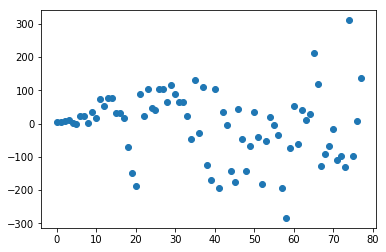

In [149]:
plt.figure()
plt.scatter(np.arange(lr_model.coef_.shape[1]),lr_model.coef_[0,:])
plt.show()

In [54]:
## print out some frequencies with higher weights (more important in LR model)
frequencies = np.arange(lr_model.coef_.shape[1])[np.abs(lr_model.coef_[0,:])>150]

for freq in frequencies:
    print(freq, 'hz')

20 hz
39 hz
41 hz
45 hz
52 hz
57 hz
58 hz
65 hz
74 hz


In [42]:
## single performance analysis
train_pred = lr_model.predict(train_X_fft)
train_loss = np.mean(np.abs(train_pred-np.ones(train_pred.shape)))

val_pred = lr_model.predict(valid_X_fft)
valid_loss = np.mean(np.abs(val_pred-np.ones(val_pred.shape)))


print ("Average \n\
train L1 pecent error is {:.4f}% \nvalid L1 pecent error is {:.4f}%".format(train_loss*100,valid_loss*100))

Average 
train L1 pecent error is 26.0139% 
valid L1 pecent error is 31.0495%


In [ ]:
## conclusion
"""
As we can see, the error is still quite bit large, and this is only one target value representation problem,
we could assume, it needs more complicated(larger) model to handle the prediction tasks.
However, with larger model, more data is required as well to have a more stable model.
It can be seen as a interative process and once after several iterations, error analysis can be performed further
to estimate the bayesian errors(model limiatation with only sensor data)

Overall this notebook, points out a possible solution to extract important frequencies with predictive power 
instead of too much human interpretation.
"""